In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdt
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np
from scipy.signal import savgol_filter
%matplotlib inline

In [2]:
#Download file
! curl -o states-daily.csv 'https://covidtracking.com/api/v1/states/daily.csv'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1275k    0 1275k    0     0  1398k      0 --:--:-- --:--:-- --:--:-- 1398k


In [3]:
#Read in covid cases csv
corona = pd.read_csv('states-daily.csv', index_col=[1,0], parse_dates=[0])
corona.head()

,,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,...,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
state,date,,,,,,,,,,,,,,,,,,,,,
AK,2020-06-24,792.0,95304.0,NaN,16.0,NaN,NaN,NaN,2.0,NaN,507.0,...,96096,0,0,e8b5866db7173c88d9b781a8d828c2eb6fd64f1b,0,0,0,0,0,NaN
AL,2020-06-24,32064.0,326695.0,NaN,667.0,2567.0,NaN,749.0,NaN,441.0,18866.0,...,358759,27,46,819fb9ba32a62a9a3594da2ecf8c320344f444a3,0,0,0,0,0,NaN
AR,2020-06-24,17375.0,254491.0,NaN,267.0,1214.0,NaN,NaN,58.0,189.0,11568.0,...,271866,3,26,4e2e733ef730182747b9f4ea119aa5e414ce2763,0,0,0,0,0,NaN
AS,2020-06-24,0.0,174.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,174,0,0,d1679d56e3b77a417891ffad72c7dd3ab09725dc,0,0,0,0,0,NaN
AZ,2020-06-24,59974.0,389214.0,NaN,2270.0,4313.0,581.0,NaN,407.0,NaN,7936.0,...,449188,79,58,04afd38f40b7ca29fe83ea208904733e39a87f5b,0,0,0,0,0,NaN


In [4]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [5]:
# Read in state populations from census
state_populations = pd.read_csv('nst-est2019-01.csv', index_col=0, thousands=',')
state_populations.index = state_populations.index.map(us_state_abbrev)
state_populations.head()

,population
state,
AL,4903185
AK,731545
AZ,7278717
AR,3017804
CA,39512223


In [6]:
# join state populations to covid data
corona = corona.join(state_populations, on='state')

In [7]:
corona.head()

,,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,...,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade,population
state,date,,,,,,,,,,,,,,,,,,,,,
AK,2020-06-24,792.0,95304.0,NaN,16.0,NaN,NaN,NaN,2.0,NaN,507.0,...,0,0,e8b5866db7173c88d9b781a8d828c2eb6fd64f1b,0,0,0,0,0,NaN,731545
AL,2020-06-24,32064.0,326695.0,NaN,667.0,2567.0,NaN,749.0,NaN,441.0,18866.0,...,27,46,819fb9ba32a62a9a3594da2ecf8c320344f444a3,0,0,0,0,0,NaN,4903185
AR,2020-06-24,17375.0,254491.0,NaN,267.0,1214.0,NaN,NaN,58.0,189.0,11568.0,...,3,26,4e2e733ef730182747b9f4ea119aa5e414ce2763,0,0,0,0,0,NaN,3017804
AS,2020-06-24,0.0,174.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,d1679d56e3b77a417891ffad72c7dd3ab09725dc,0,0,0,0,0,NaN,55641
AZ,2020-06-24,59974.0,389214.0,NaN,2270.0,4313.0,581.0,NaN,407.0,NaN,7936.0,...,79,58,04afd38f40b7ca29fe83ea208904733e39a87f5b,0,0,0,0,0,NaN,7278717


In [8]:
# sort on state
corona.sort_index(inplace=True)
# add percent of cases that are negative
corona['percentNegative'] = 100.0* corona['negativeIncrease'] / corona['totalTestResultsIncrease']

In [9]:
columns_to_plot = ['positiveIncrease', 'totalTestResultsIncrease', 'percentNegative']
titles = ['# Positive', '# Tests', '% Negative']


In [10]:
# is this increasing over the time span?
def isIncreasing(x):
    if x[0] < x[-1]:
        return True
    else:
        return False

In [11]:
# add columns for rolling average, and if it is increasing
for col in columns_to_plot:
    new_col_name = col+'Rolling'
    corona[new_col_name] = corona.groupby(level=0)[col].rolling(window=7).mean().values
    
    comparison_name = col+'IsIncreasing'
    corona[comparison_name] = corona.groupby(level=0)[new_col_name].rolling(window=7).apply(isIncreasing, raw=True).values
        


In [12]:
# create plots for each metric
def plot_bar_increasing (ts, title, isIncreasing, ax, increaseGreen=True, population=None):
    if increaseGreen:
        mapping = {True: 'g', False: 'r'}
    else:
        mapping = {False: 'g', True: 'r'}
        
    if population is not None:
        ts = 1e5*ts / population
    
    ts.plot(kind='bar',
           color = isIncreasing.map(mapping),
           ax=ax)
    ax.set_ylabel(title)

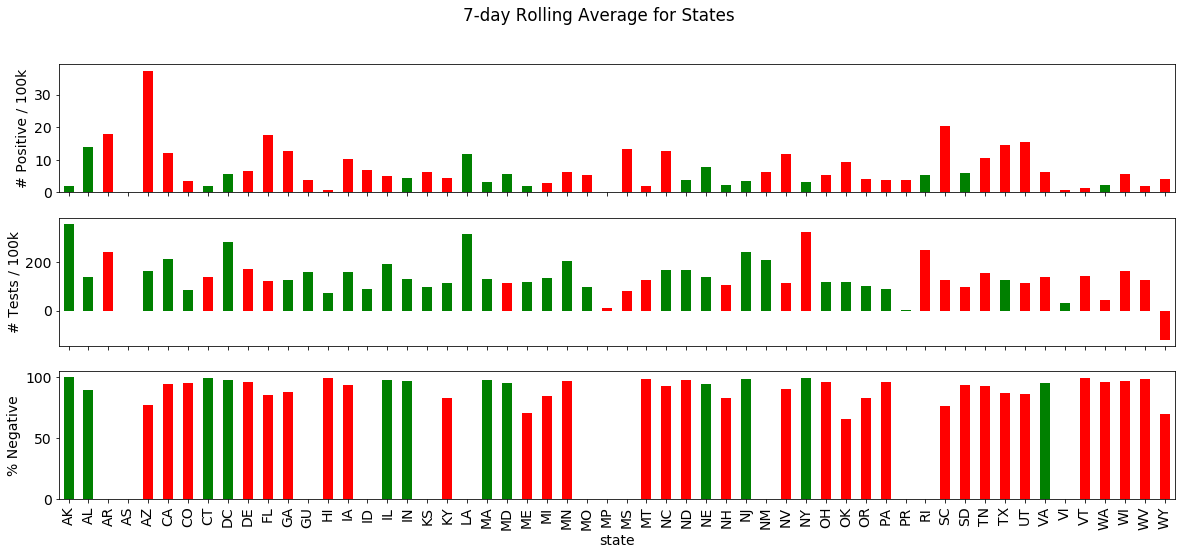

In [13]:
#plot 3 metrics
plt.rcParams.update({'font.size': 14})


# get most recent value for each state
corona_to_plot = corona.groupby(level='state').tail(1).reset_index(level=1, drop=True)

#create plot
fig, axs = plt.subplots(len(columns_to_plot), 1, sharex=True, figsize=(20,8))

# fill na with zeros
corona_to_plot.fillna(0.0, axis=1, inplace=True)

columns_to_plot = ['positiveIncrease', 'totalTestResultsIncrease', 'percentNegative']
titles = ['# Positive', '# Tests', '% Negative']

plt.suptitle('7-day Rolling Average for States')

# plot positive cases
plot_bar_increasing(corona_to_plot['positiveIncrease'+'Rolling'], 
                    '# Positive / 100k', 
                    corona_to_plot['positiveIncrease'+'IsIncreasing'],
                    ax=axs[0],
                    increaseGreen=False,
                    population=corona_to_plot['population'])


#plot tests run
plot_bar_increasing(corona_to_plot['totalTestResultsIncrease'+'Rolling'], 
                    '# Tests / 100k', 
                    corona_to_plot['totalTestResultsIncrease'+'IsIncreasing'],
                    ax=axs[1],
                    increaseGreen=True,
                    population=corona_to_plot['population'])

#plot pct negative tests
plot_bar_increasing(corona_to_plot['percentNegative'+'Rolling'], 
                    '% Negative', 
                    corona_to_plot['percentNegative'+'IsIncreasing'],
                    ax=axs[2],
                    increaseGreen=True)


plt.savefig('state_by_state.pdf')

In [14]:
# is each metric improving or declining 

pos_mapping = {True: 1, False: -1}
neg_mapping = {False: 1, True: -1}

def isIncreasingZeroCheck(pct_neg, pct_neg_incr):
    if pct_neg < 1:
        return 0
    if pct_neg_incr > 0:
        return 1
    else:
        return -1

rate_mappings = []
rate_mappings.append(corona_to_plot['positiveIncrease'+'IsIncreasing'].map(neg_mapping))
rate_mappings.append(corona_to_plot['totalTestResultsIncrease'+'IsIncreasing'].map(pos_mapping))
rate_mappings.append(corona_to_plot.apply(lambda row: isIncreasingZeroCheck(row['percentNegative'], row['percentNegative'+'IsIncreasing']), axis=1)
)

In [15]:
# are the metrics at good levels?
level_mappings = []
level_mappings.append((1e5*corona_to_plot['positiveIncreaseRolling']/corona_to_plot['population']).apply(lambda x: 1 if x < 10.0 else -1))
level_mappings.append(corona_to_plot['percentNegativeRolling'].apply(lambda x: 0 if x < 1 else (1 if x > 90 else -1)))



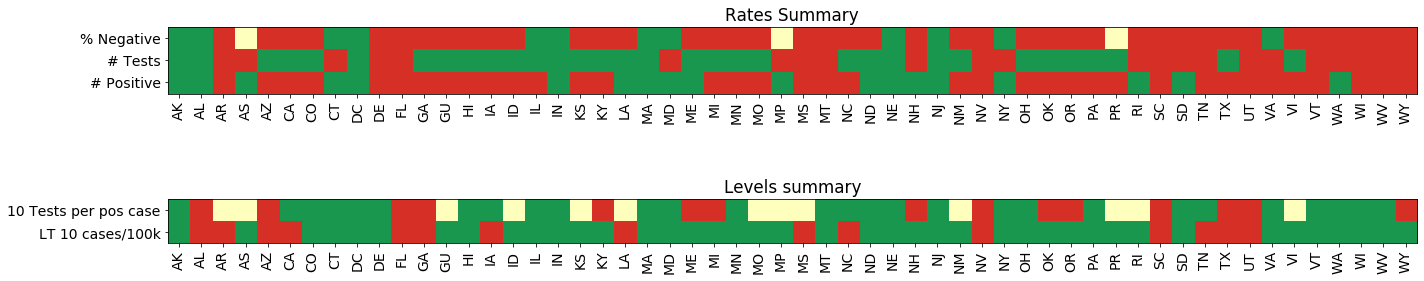

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(20,5))


#rates summary
im = axs[0].imshow(rate_mappings, cmap='RdYlGn', vmin=-1.25, vmax=1.25)
axs[0].set_title('Rates Summary')
# We want to show all ticks...
axs[0].set_xticks(np.arange(len(corona_to_plot.index)))
axs[0].set_yticks(np.arange(3))
# ... and label them with the respective list entries
axs[0].set_xticklabels(corona_to_plot.index.values)
axs[0].set_yticklabels(titles)
axs[0].set_ylim(-0.5,2.5)
plt.setp(axs[0].xaxis.get_majorticklabels(), rotation=90)

#level summary
im = axs[1].imshow(level_mappings, cmap='RdYlGn', vmin=-1.25, vmax=1.25)
axs[1].set_title('Levels summary')
# We want to show all ticks...
axs[1].set_xticks(np.arange(len(corona_to_plot.index)))
axs[1].set_yticks(np.arange(2))
# ... and label them with the respective list entries
axs[1].set_xticklabels(corona_to_plot.index.values)
axs[1].set_yticklabels(['LT 10 cases/100k', '10 Tests per pos case'])
axs[1].set_ylim(-0.5,1.5)
plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=90)

plt.tight_layout()
plt.savefig('state_by_state_summary.pdf')